In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from functools import partial
import numpy as np
import math
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_dir = "/content/drive/MyDrive/TT/tfrecords"
BATCH_SIZE = 8
IMAGE_SIZE = [640, 640]
AUTOTUNE = tf.data.AUTOTUNE
GRID_SIZE = 8
# SQUARES = 80
SQUARES = 640 // GRID_SIZE

In [ ]:
train_filenames = tf.io.gfile.glob(data_dir + "/train*")
val_filenames = tf.io.gfile.glob(data_dir + "/test*")
raw_train = tf.data.TFRecordDataset(train_filenames)

In [ ]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.uint8)
    image = tf.reshape(image, [*IMAGE_SIZE])
    #inverted_image = tf.bitwise.invert(image)
    #return inverted_image
    return image


In [ ]:
def bbox_gen(x1, y1, x2, y2):
    x1 = x1.numpy().tolist()
    x2 = x2.numpy().tolist()
    y1 = y1.numpy().tolist()
    y2 = y2.numpy().tolist()
    Y = np.zeros((SQUARES, SQUARES, 5), dtype=np.float32)
    for i in range(len(x1)):
#        print(x1[i], x2[i], x2[i] - x1[i])
        center_x, center_y = (x2[i] + x1[i]) * 320, (y2[i] + y1[i]) * 320
        mx, my = math.floor( center_x // GRID_SIZE), math.floor( center_y // GRID_SIZE)
        if mx == SQUARES:
            mx = SQUARES - 1
        if my == SQUARES:
            my = SQUARES - 1
        channels = Y[my][mx]
        channels[0] = 1.0
        channels[1] = math.floor(x1[i]*640) - (mx*GRID_SIZE)
        channels[2] = math.floor(y1[i]*640) - (my*GRID_SIZE)
        channels[3] = math.floor(x2[i]*640) - (mx*GRID_SIZE)
        channels[4] = math.floor(y2[i]*640) - (my*GRID_SIZE)
    return Y

In [ ]:
def read_tfrecord(example):
    tfrecord_format = (
    {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width':  tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    })
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image/encoded"])
    x1 = example['image/object/bbox/xmin']
    x2 = example['image/object/bbox/xmax']
    y1 = example['image/object/bbox/ymin']
    y2 = example['image/object/bbox/ymax']
    bboxes = tf.py_function(func=bbox_gen, inp=[x1, y1, x2, y2], Tout=tf.float32)
    return image, bboxes

In [ ]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(buffer_size=1024).repeat(4).cache().prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE)
    return dataset

In [ ]:
train = get_dataset(train_filenames)
val = get_dataset(val_filenames)

In [ ]:
image_batch_val = next(iter(val))

In [ ]:
def show_boxes(image_batch):
    xs, ys = image_batch
    xs = xs.numpy()
    plt.figure(figsize=(50,50))
    for n in range(4):
        Xrgb = cv2.cvtColor(xs[n], cv2.COLOR_GRAY2RGB)
        y = ys[n]

        ax = plt.subplot(4, 4, n + 1)
        plt.axis("off")
    
        for mx in range(SQUARES):
            for my in range(SQUARES):
                channels = y[my][mx]
                prob, x1, y1, x2, y2 = channels
                if prob == 1:
                # bounding box pred
                    px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                    px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                    cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (0,255,0), 3)
        plt.imshow(Xrgb)

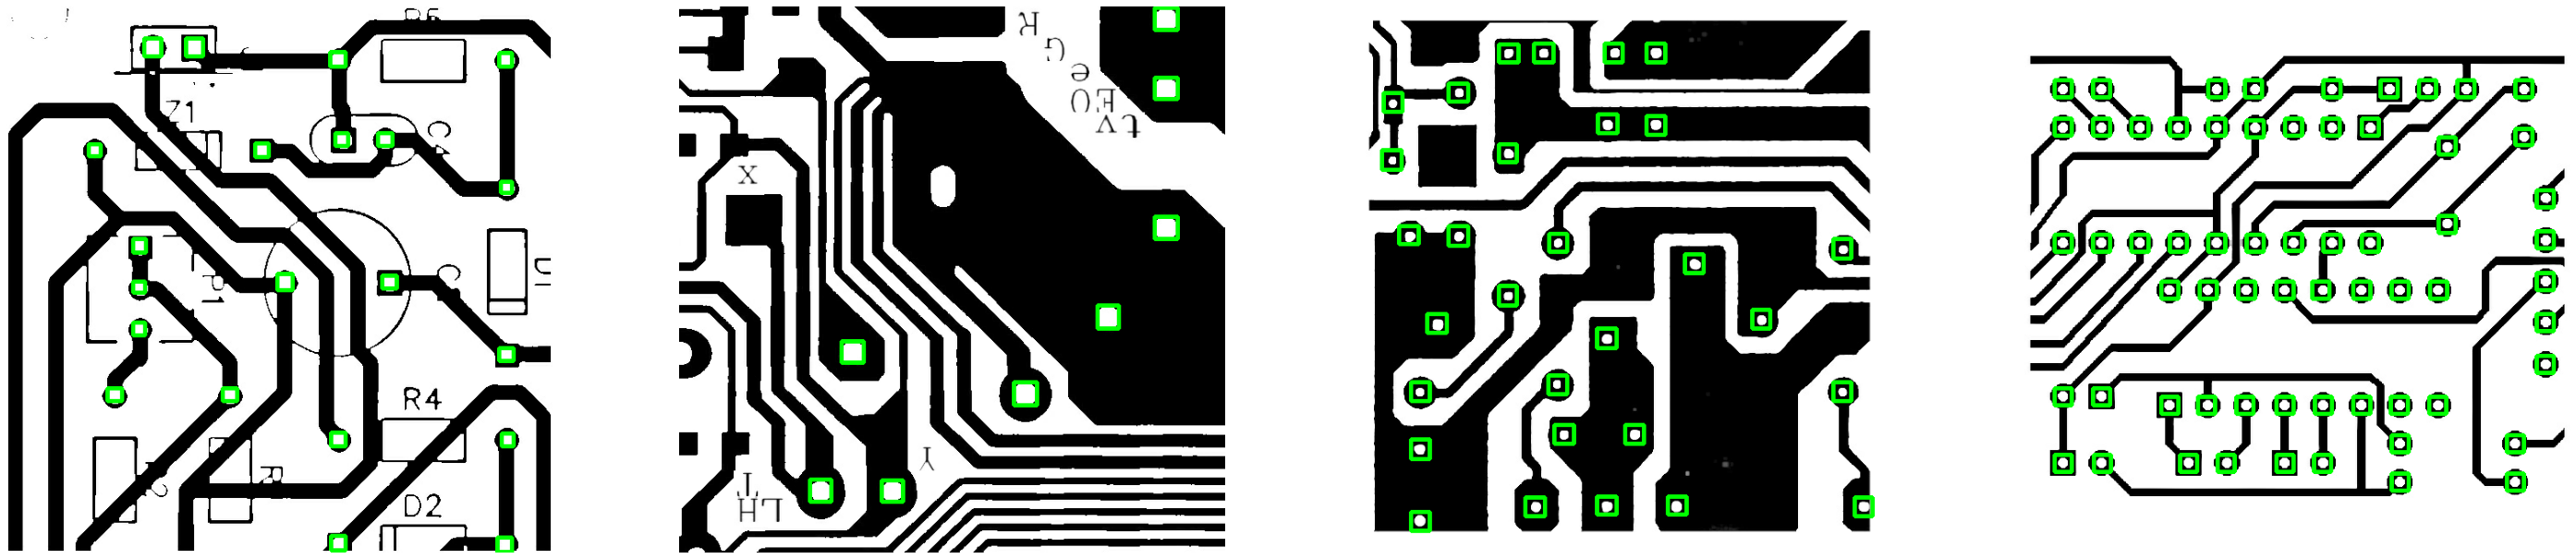

In [ ]:
show_boxes(image_batch_val)

# Model

In [ ]:
x = x_input = tf.keras.layers.Input(shape=(640, 640, 1))

y = tf.keras.layers.Conv2D(16, kernel_size=120, strides=(4,4), padding="same", activation='relu')(x)
y = tf.keras.layers.BatchNormalization()(y)

y = tf.keras.layers.Conv2D(8, kernel_size=20, strides=(8,8), padding="same", activation='relu')(x)
y = tf.keras.layers.BatchNormalization()(y)


z = tf.keras.layers.Conv2D(8, kernel_size=80, strides=(8,8), padding="same", activation='relu')(x)
z = tf.keras.layers.BatchNormalization()(z)

x = tf.keras.layers.Conv2D(16, kernel_size=60, strides=(2,2), padding='same', activation='relu')(x)
x = tf.keras.layers.AvgPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x) # size: 160X160

x = tf.keras.layers.Conv2D(8, kernel_size=10, padding='same', activation='relu')(x)
x = tf.keras.layers.AvgPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)  # size: 80X80

x = tf.keras.layers.Concatenate()([x,y,z])
x = tf.keras.layers.Dropout(0.1)(x)

x_prob = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = tf.keras.layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)

# ---

gate = tf.where(x_prob > 0.8, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate

# ---

x = tf.keras.layers.Concatenate()([x_prob, x_boxes])

model = tf.keras.models.Model(x_input, x)

In [ ]:
print("Total model weights:", model.count_params())

Total model weights: 126085


In [ ]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.huber(y_true, y_pred)
    return tf.reduce_mean(loss)

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss_func, optimizer=opt)

In [ ]:
checkpoint_filepath = '.'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model.fit(train, validation_data=val, epochs=150, callbacks=[model_checkpoint_callback])

Epoch 1/150
155/155 [==============================] - 35s 212ms/step - loss: 26373.8984 - val_loss: 22634.2754
Epoch 2/150
155/155 [==============================] - 29s 189ms/step - loss: 20056.4062 - val_loss: 20347.3848
Epoch 3/150
155/155 [==============================] - 29s 190ms/step - loss: 14599.4092 - val_loss: 14754.6475
Epoch 4/150
155/155 [==============================] - 29s 190ms/step - loss: 10232.6719 - val_loss: 6072.2534
Epoch 5/150
155/155 [==============================] - 30s 191ms/step - loss: 7139.7871 - val_loss: 4662.3906
Epoch 6/150
155/155 [==============================] - 30s 192ms/step - loss: 5077.9985 - val_loss: 3322.9814
Epoch 7/150
155/155 [==============================] - 29s 188ms/step - loss: 3719.9958 - val_loss: 2013.6970
Epoch 8/150
155/155 [==============================] - 29s 190ms/step - loss: 2822.2708 - val_loss: 2315.9070
Epoch 9/150
155/155 [==============================] - 30s 191ms/step - loss: 2209.9333 - val_loss: 1181.4998
Epo

In [ ]:
model.save("./last_idea6.h5")

In [ ]:
def show_predict(X, y_true, threshold=0.45):
    X = X.numpy().copy()
    y = model.predict(X)
    plt.figure(figsize=(50,50))
    for n in range(4):
        Xrgb = cv2.cvtColor(X[n], cv2.COLOR_GRAY2RGB)
        y_pred = y[n]
        single_y_true = y_true.numpy()[n]

        ax = plt.subplot(2, 2, n + 1)
        plt.axis("off")
    
        for mx in range(SQUARES):
            for my in range(SQUARES):
                channels = y_pred[my][mx]
                channelst = single_y_true[my][mx]
                prob, x1, y1, x2, y2 = channels
                tprob, tx1, ty1, tx2, ty2 = channelst

                if tprob == 1:
                    # bounding box true
                    px1t, py1t = (mx * GRID_SIZE) + tx1, (my * GRID_SIZE) + ty1
                    px2t, py2t = (mx * GRID_SIZE) + tx2, (my * GRID_SIZE) + ty2
                    cv2.rectangle(Xrgb, (int(px1t), int(py1t)), (int(px2t), int(py2t)), (0,255,0), 2)
                # if prob < threshold we won't show any thing
                if prob < threshold:
                    continue

                # bounding box pred
                px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)

                #print(int(px), int(py), int(px + x2), int(py + y2))
        plt.imshow(Xrgb)

In [ ]:
image_batch, y = next(iter(val))

1/1 [==============================] - 2s 2s/step


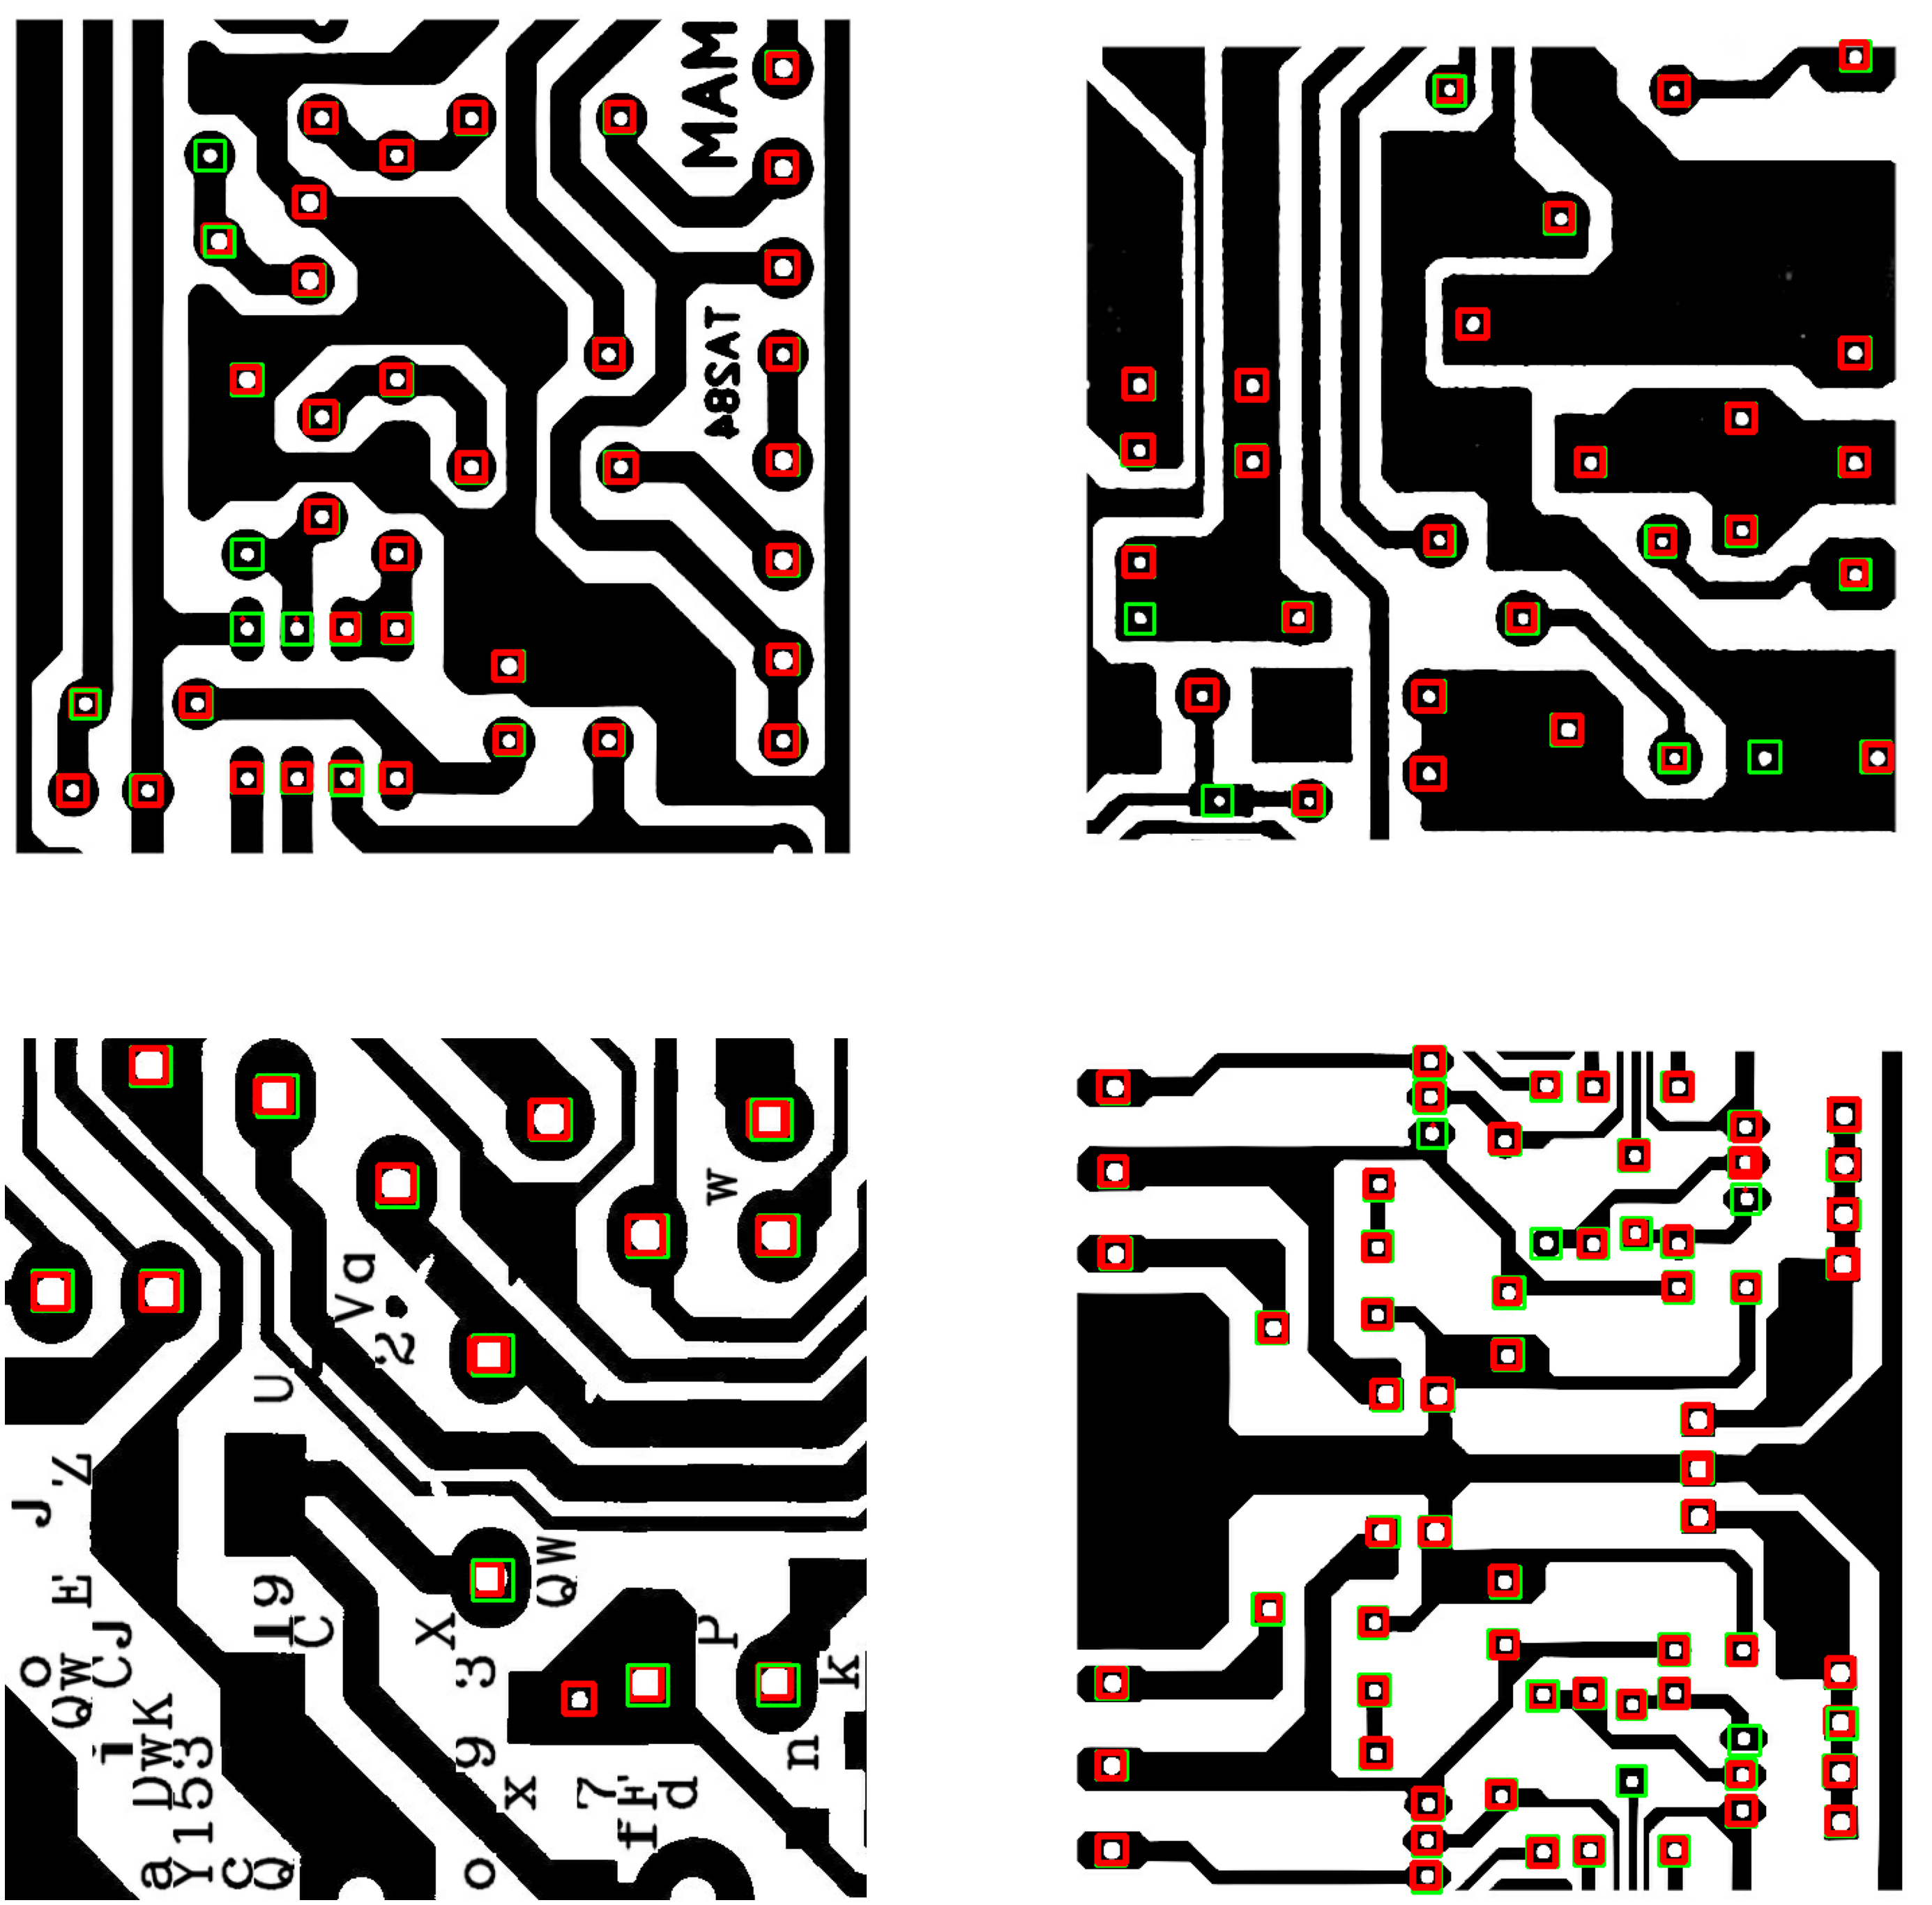

In [ ]:
show_predict(image_batch, y)

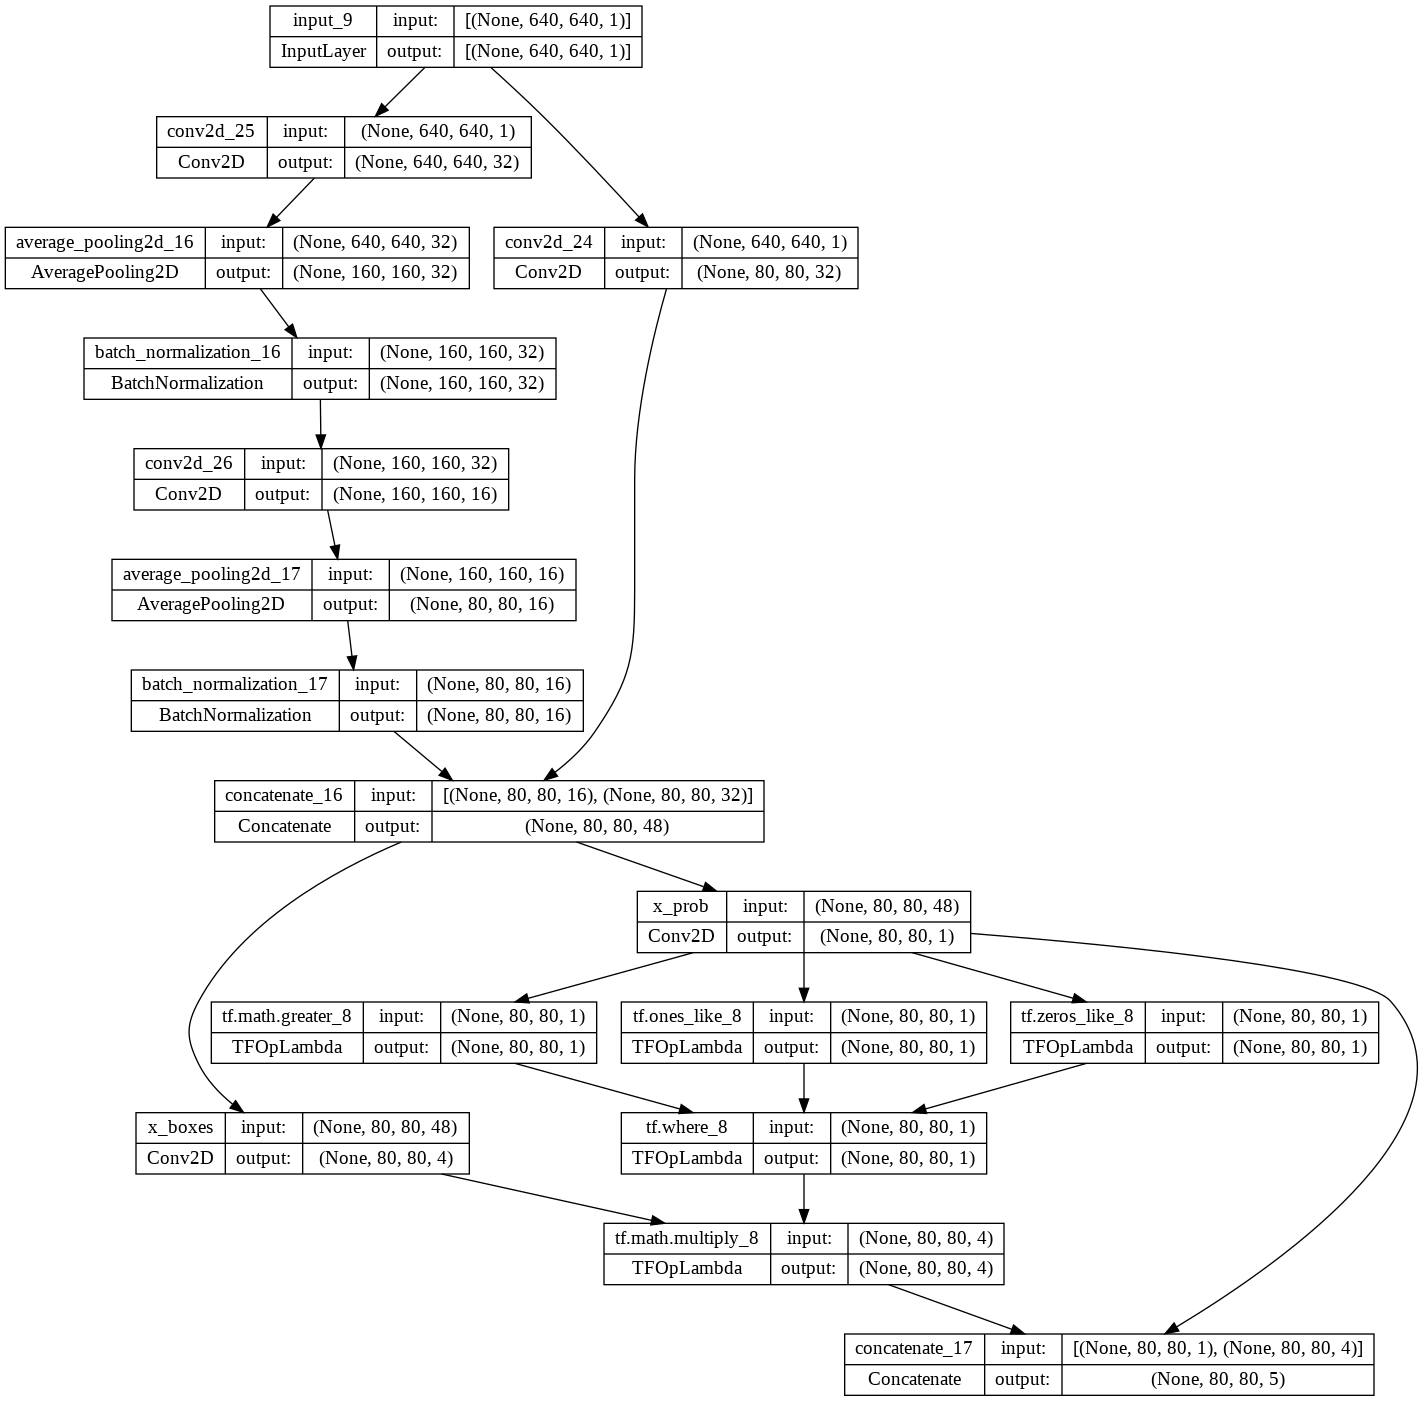

In [ ]:
tf.keras.utils.plot_model(model, to_file='fixed_data.png', show_shapes=True)

In [ ]:
import pandas as pd
# plotting the measurments in the history object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1000)
plt.xlabel("epoch")

In [ ]:
tf.keras.utils.plot_model(model, to_file='last_idea6.png', show_shapes=True)

In [ ]:
def show_one_predictions(X, model, threshold=0.15):
    X = X.numpy().copy()
    y = model.predict(X)

    plt.figure(figsize=(10,10))

    Xrgb = cv2.cvtColor(X[0], cv2.COLOR_GRAY2RGB)
    Xrgb = Xrgb.astype(np.uint8)
    y_pred = y[0]

    ax = plt.subplot()
    plt.axis("off")
    
    for mx in range(SQUARES):
        for my in range(SQUARES):
            channels = y_pred[my][mx]
            prob, x1, y1, x2, y2 = channels
            if prob < threshold:
                continue

            # bounding box pred
            px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
            px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
            cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)

                #print(int(px), int(py), int(px + x2), int(py + y2))
    plt.imshow(Xrgb)

In [ ]:
model = tf.keras.models.load_model('./fixed_data.h5', compile=False)

In [ ]:
img = tf.keras.utils.load_img(
    "./sub_img_bin.jpg", target_size=(640,640)
)
img_array = tf.keras.utils.img_to_array(img)
gray = img_array[:,:,0]
gray = gray.astype(np.uint8)
gray = tf.bitwise.invert(gray)
gray = tf.expand_dims(gray, 0) # Create a batch

In [ ]:
gray.shape

TensorShape([1, 640, 640])

1/1 [==============================] - 0s 134ms/step


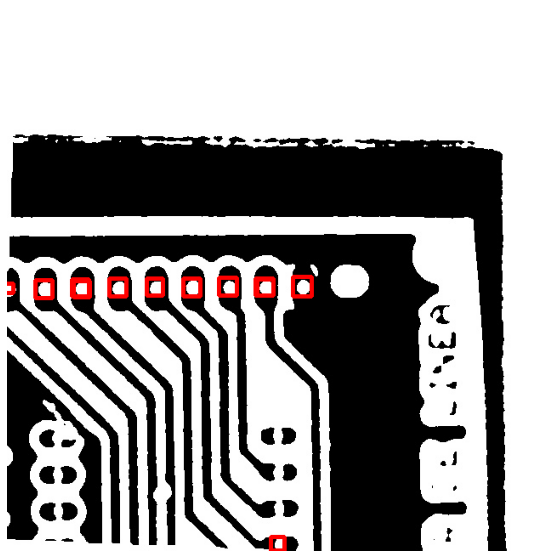

In [ ]:
show_one_predictions(gray, new_model)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
SQUARES = 80
GRID_SIZE = 8
img_array = cv2.imread("./img_218.jpg", 0)
_, img_array = cv2.threshold(img_array, 220, 255, cv2.THRESH_BINARY)
#img_array = img_gui
#img_array = img_array[710:1660, 550:1540]
# img_array = img_array[700:1000, 1000:1300]
#image_center = tuple(np.array(img_array.shape[1::-1]) / 2)
#rot_mat = cv2.getRotationMatrix2D(image_center, -2.25, 1.0)
#img_array = cv2.warpAffine(img_array, rot_mat, img_array.shape[1::-1], flags=cv2.INTER_LINEAR)
# img_array = img_array[515:1465, 600:1550]
# img_array = cv2.resize(img_array, (640, 640), interpolation= cv2.INTER_LINEAR)
#y = 1660 - 700
#x = 1540 - 550
#ym = y // 3
#xm = x // 3
ym = 640 // 3
xm = 640 // 3
imgs = []
for j in range(1,4):
    for i in range(1,4):
        # print(i ,i*xm, j, j*ym)
        sub_img = img_array[(j-1)*ym: (j*ym), (i-1)*xm: i*xm]
        sub_img = cv2.resize(sub_img, (640, 640), interpolation= cv2.INTER_LINEAR)
        sub_img = cv2.medianBlur(sub_img, 5)
        sub_img = unsharp_mask(sub_img, radius=5, amount=11)
        sub_img *= 255
        np.floor(sub_img)
        #sub_img = cv2.bitwise_not(sub_img)
        
        sub_img = sub_img.astype(np.float32)
        imgs.append(np.expand_dims(sub_img, axis=-1))

In [ ]:
def show_multiple_predictions(X, threshold=0.4):
    X = X.copy()
    y = model.predict(X)

    plt.figure(figsize=(50,50))
    for n in range(9):
        Xrgb = cv2.merge([X[n],X[n],X[n]])
        y_pred = y[n]

        ax = plt.subplot(3, 3, n + 1)
        plt.axis("off")
    
        for mx in range(SQUARES):
            for my in range(SQUARES):
                channels = y_pred[my][mx]
                prob, x1, y1, x2, y2 = channels
                # if prob < threshold we won't show any thing
                if prob < threshold:
                    continue

                # bounding box pred
                px1, py1 = (mx * GRID_SIZE) + x1, (my * GRID_SIZE) + y1
                px2, py2 = (mx * GRID_SIZE) + x2, (my * GRID_SIZE) + y2
                cv2.rectangle(Xrgb, (int(px1), int(py1)), (int(px2), int(py2)), (255,0,0), 3)

                #print(int(px), int(py), int(px + x2), int(py + y2))
        plt.imshow(Xrgb)

1/1 [==============================] - 1s 1s/step


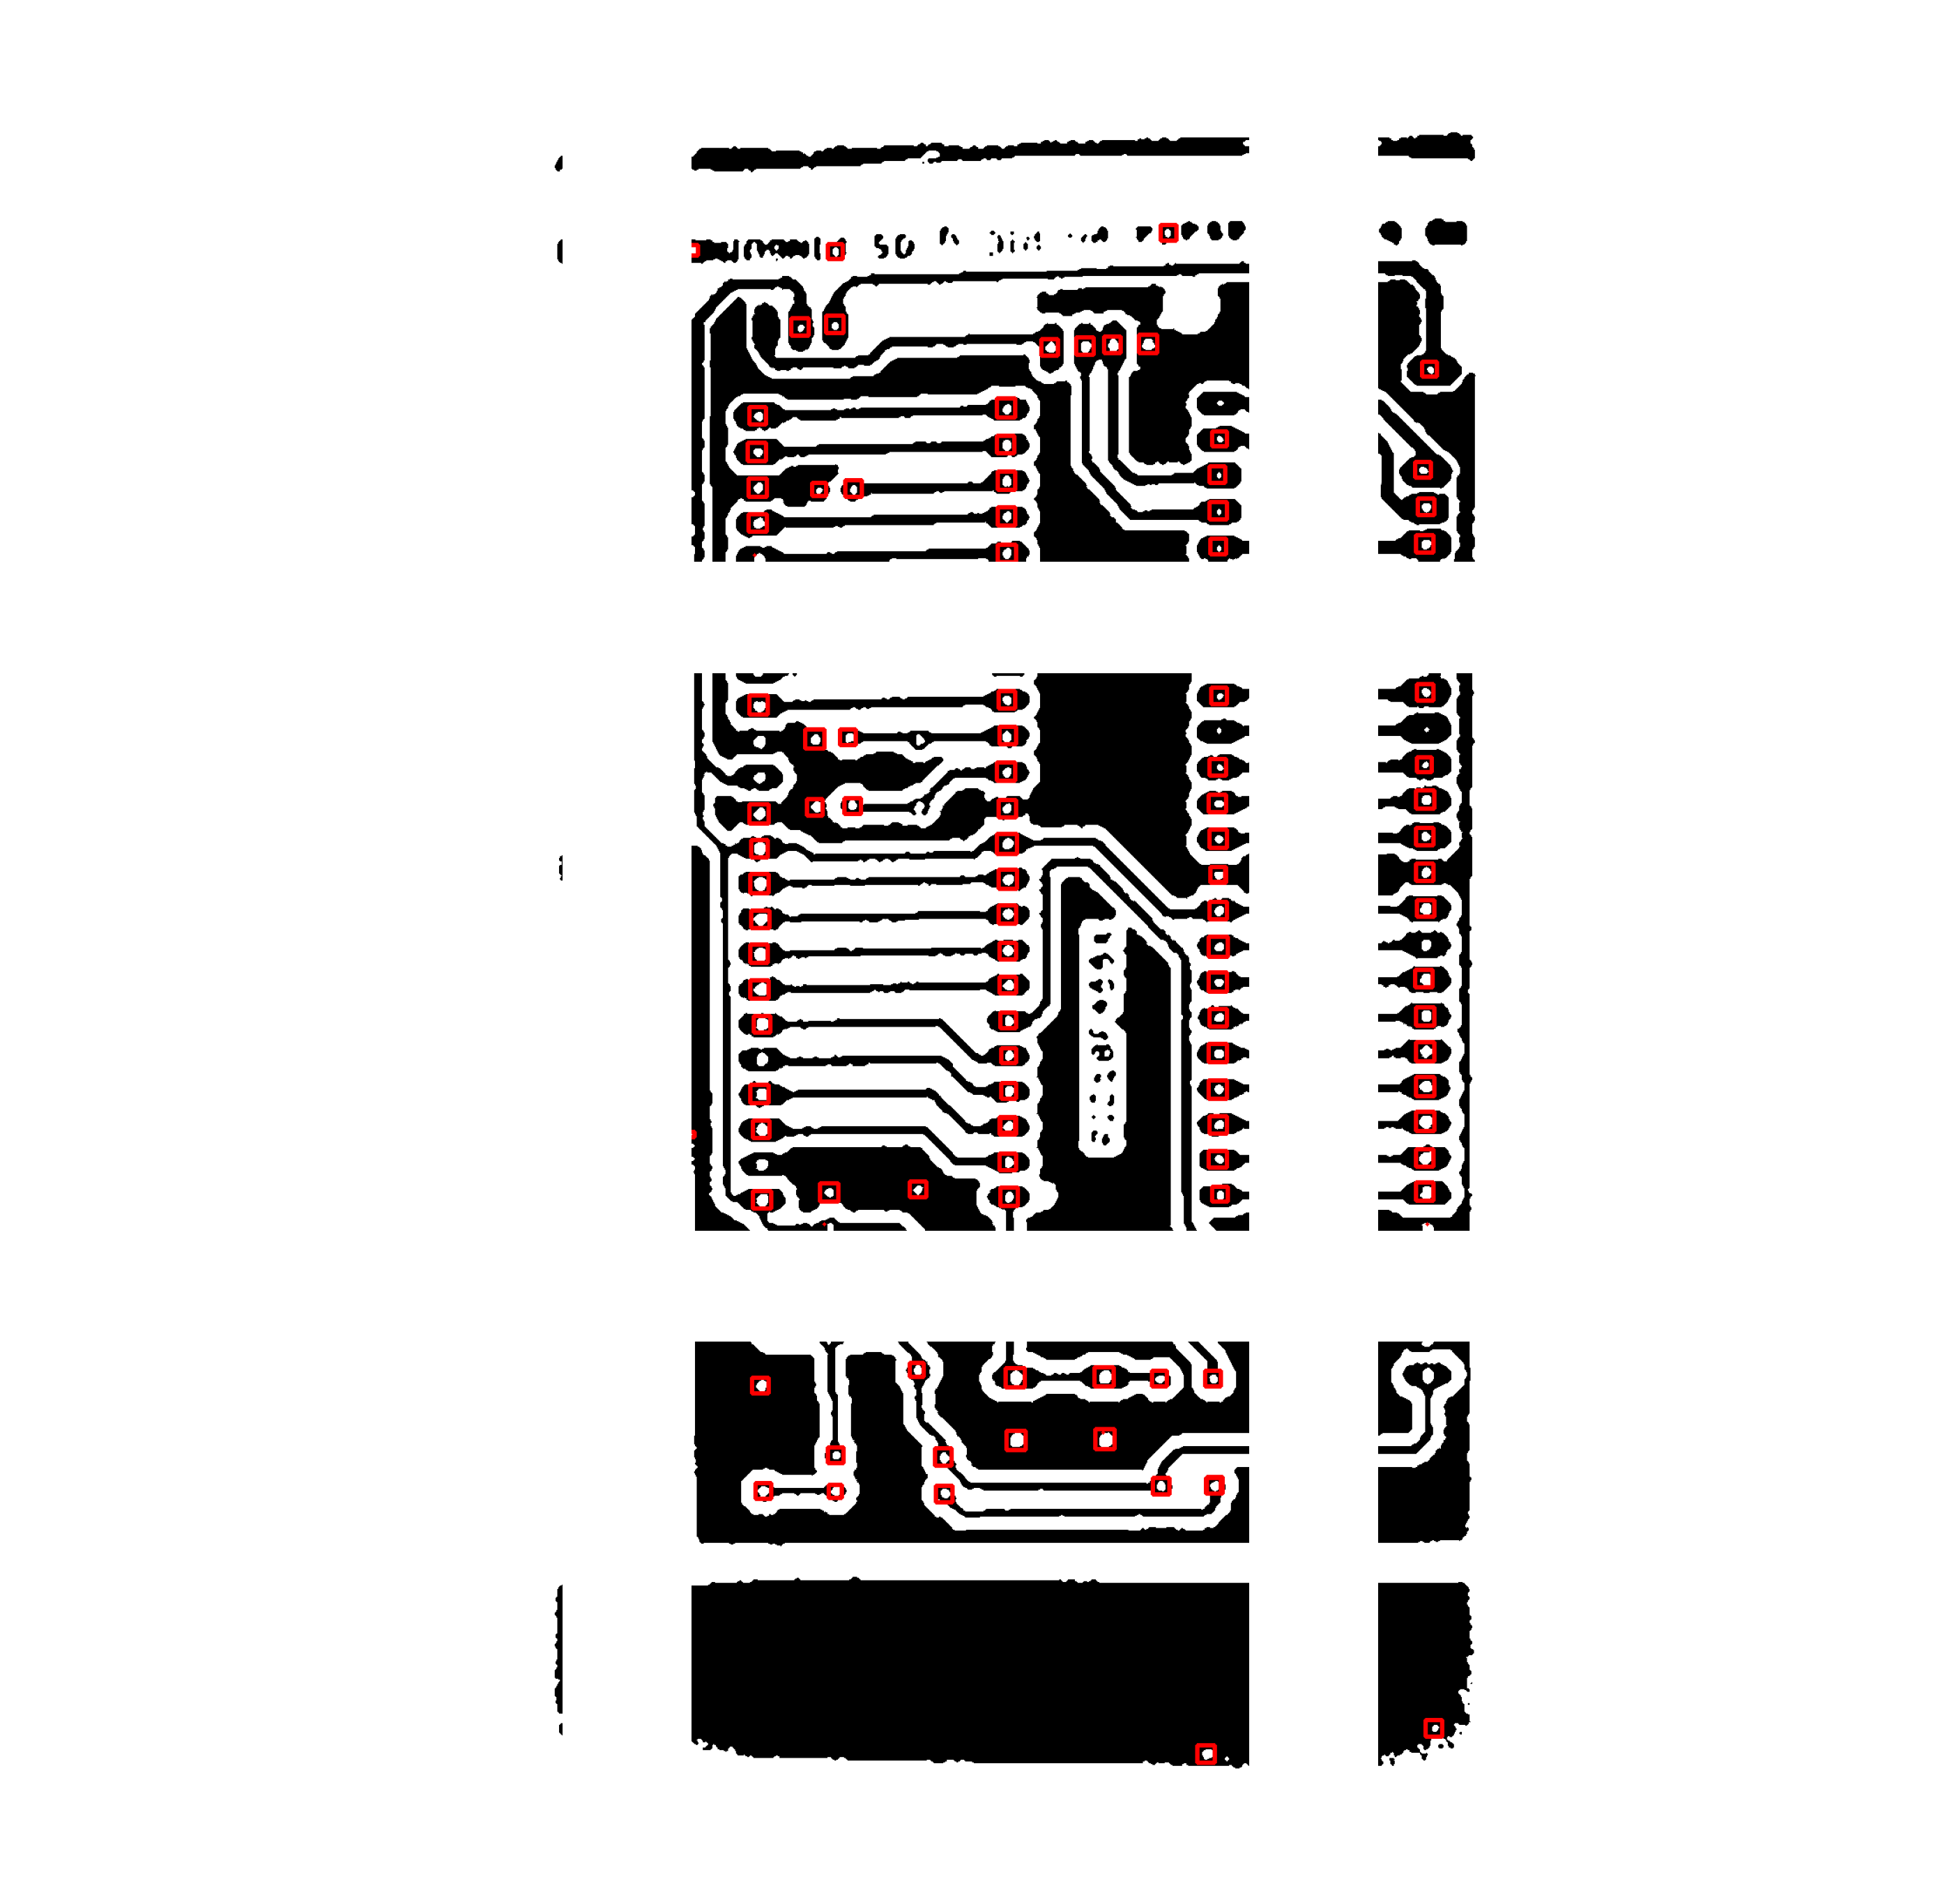

In [ ]:
show_multiple_predictions(np.stack(imgs, axis=0))

In [ ]:
import time
class ProcessPinHolesCenters():
    def __init__(self, imgs):
        self.imgs = imgs
        self.predictions = []
        self.coords_processed = []
        self.predict_cnn()
        self.transform_predictions_to_coords()

    def predict_cnn(self):
        model_path = "./fixed_data.h5"
        model = tf.keras.models.load_model(model_path, compile=False)

        for sub_img in self.imgs:
            self.predictions.append(model.predict(np.expand_dims(sub_img, axis=0)))

    def transform_predictions_to_coords(self):
        threshold = 0.3
        GRID_SIZE = 8
        for i in range(1,10):
            for mx in range(80):
                for my in range(80):
                    # print(i)
                    # print(self.predictions[i-1].shape)
                    channels = self.predictions[i-1][0][my][mx]
                    # print(channels.shape)
                    prob, x1, y1, x2, y2 = channels

                    if prob < threshold:
                        continue

                    px1, py1 = int((mx * GRID_SIZE) + x1), int((my * GRID_SIZE) + y1)
                    px2, py2 = int((mx * GRID_SIZE) + x2), int((my * GRID_SIZE) + y2)
                    # print(px1, py1, px2, py2)
                    cx, cy, r = self.get_sub_image_center(self.imgs[i-1], px1, py1, px2, py2)
                    if cx == -1:
                        continue
                    #cx, cy = ((mx * GRID_SIZE) + cx) // 3, ((my * GRID_SIZE) + cy) // 3
                    cx = cx // 3
                    cy = cy // 3
                    if i == 2:
                        cx += 213
                        cy += 1
                    if i == 3:
                        cx += 426
                        cy += 1
                    if i == 4:
                        cy += 213
                    if i == 5:
                        cy += 213
                        cx += 213
                    if i == 6:
                        cx += 426
                        cy += 213
                    if i == 7:
                        cy += 426
                    if i == 8:
                        cx += 213
                        cy += 426
                    if i == 9:
                        cx += 426
                        cy += 426

                    self.coords_processed.append((cx, cy, r))

    def get_sub_image_center(self, img, x1, y1, x2, y2):
        #img = cv2.bitwise_not(img)
        sub_image = img[y1:y2, x1:x2]
        #sub_image = img_not[y1:y2, x1:x2]
        sub_image = sub_image.astype(np.uint8)
        try:
            detected_circles = cv2.HoughCircles(
                                    sub_image,
                                    cv2.HOUGH_GRADIENT, 1, 40,
                                    param1 = 50,
                                    param2 = 2,
                                    minRadius = 5,
                                    maxRadius = 9
                            )
        except:
            return (-1, -1, -1)
        sub_image = cv2.merge((sub_image, sub_image, sub_image))
        try:
            for pt in detected_circles[0, :]:
                # circle coords
                a, b, r = int(pt[0]), int(pt[1]), int(pt[2])
                new_x1 = x1 + a
                new_y1 = y1 + b
                cv2.circle(sub_image, (a,b), 1, (255,0,0), -1)
                cv2.circle(sub_image, (a,b), r, (255,0,0), 1)
                #plt.figure(figsize=(5,5))
                #ax = plt.subplot()
                #plt.axis("off")
                #plt.imshow(sub_image)
                return (new_x1, new_y1, r)
        except:
            return (-1, -1, -1)

In [ ]:
centers = ProcessPinHolesCenters(imgs)

1/1 [==============================] - 0s 128ms/step


In [ ]:
img_ = cv2.imread("./juanito3.jpg")
#img_ = img_[710:1660, 550:1540]

image_center = tuple(np.array(img_.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, -2.25, 1.0)
img_ = cv2.warpAffine(img_, rot_mat, img_.shape[1::-1], flags=cv2.INTER_LINEAR)
img_ = cv2.resize(img_, (640, 640), interpolation= cv2.INTER_LINEAR)

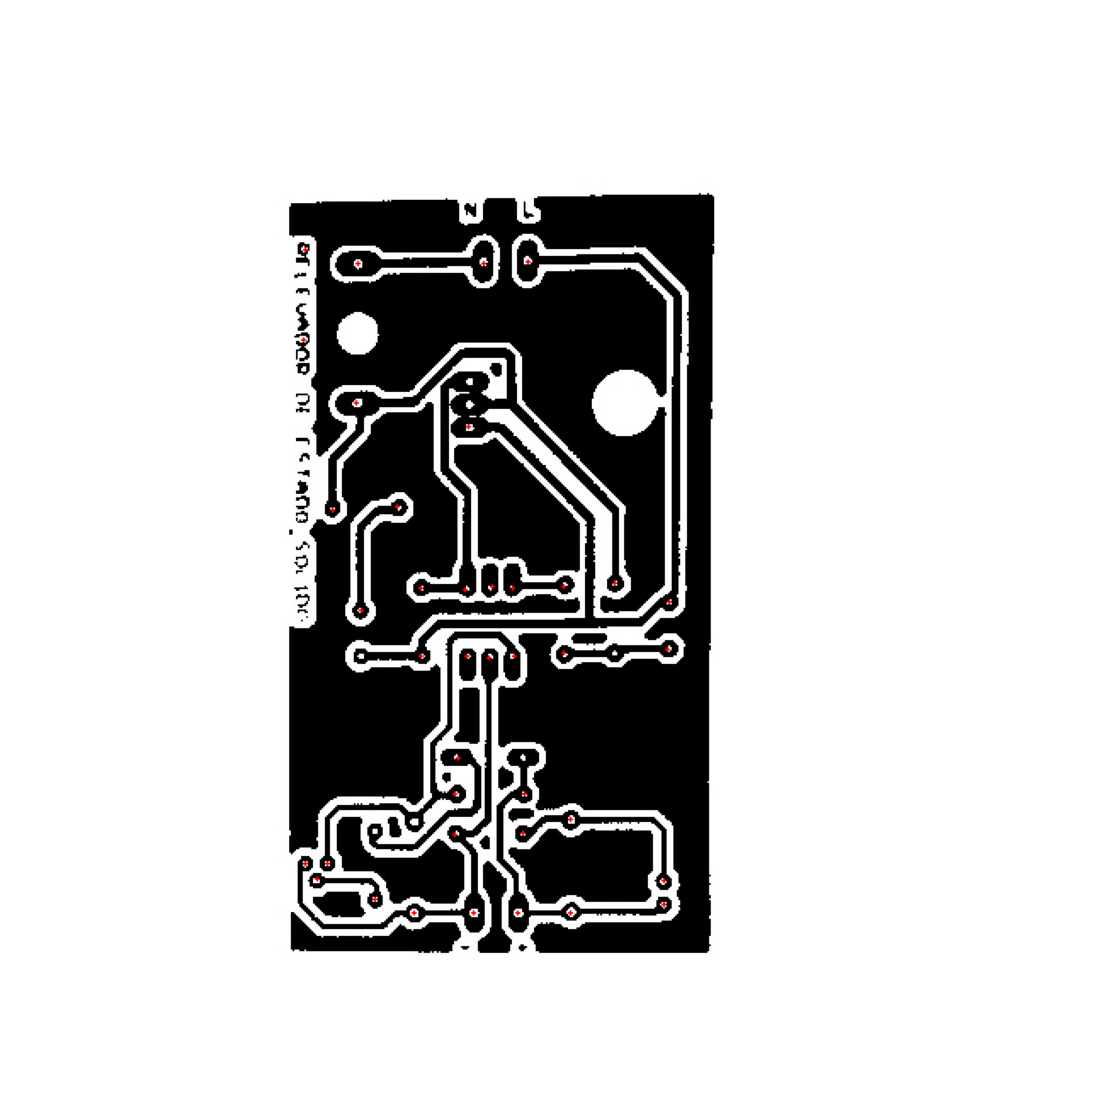

In [ ]:
img_ = cv2.imread("./img_218.jpg")
for circle_coord in centers.coords_processed:
    x, y, r = circle_coord
    cv2.circle(img_, (x,y), 1, (255,0,0), -1)
plt.figure(figsize=(20,20))
ax = plt.subplot()
plt.axis("off")
plt.imshow(img_)

In [ ]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)
#m2tex(model)

In [ ]:

class ImagePreprocessing():
    def __init__(self, img_path):
        self.img_path = img_path
        self.img_array = cv2.imread(img_path, 0)

    def crop_rotate(self, img, crops_coords=None, angle=0):
        if crops_coords:
            y1, y2, x1, x2 = crops_coords
            img = img[y1: y2, x1: x2]
        image_center = tuple(np.array(img.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return img

    def do_multiple_images(self):
        _, img_array = cv2.threshold(self.img_array, 230, 255, cv2.THRESH_BINARY)
        ym = img_array.shape[0] // 3
        xm = img_array.shape[1] // 3
        imgs = []
        for j in range(1,4):
            for i in range(1,4):
                sub_img = img_array[(j-1)*ym: (j*ym), (i-1)*xm: i*xm]
                sub_img = cv2.resize(sub_img, (640, 640), interpolation= cv2.INTER_LINEAR)
                # if the binary image has the pin holes color black, invert it:
                # sub_img = cv2.bitwise_not(sub_img)
                sub_img = cv2.medianBlur(sub_img, 5)
                sub_img = unsharp_mask(sub_img, radius=10, amount=25)
                sub_img *= 255
                np.floor(sub_img)
                sub_img = sub_img.astype(np.float32)
                imgs.append(np.expand_dims(sub_img, axis=-1))
        return imgs


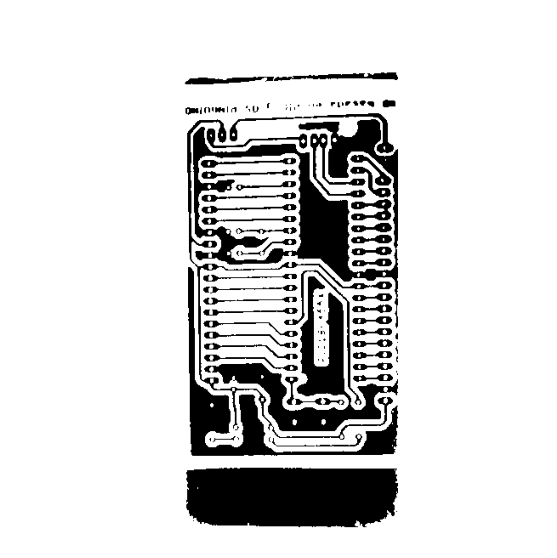

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
prep_img_home = ImagePreprocessing("./img_266.jpg")
        # Getting the last img taken by the raspberry
orig_img_gui = prep_img_home.img_array
        # preprocessing
img_gui = prep_img_home.crop_rotate(orig_img_gui, (700,1660,550,1540), -2.75)
img_gui = prep_img_home.crop_rotate(img_gui, None, 180)
img_gui = cv2.resize(img_gui, (640, 640), interpolation= cv2.INTER_LINEAR)
        # Binarizing
_, img_gui = cv2.threshold(img_gui, 236, 255, cv2.THRESH_BINARY)
img_gui = cv2.erode(img_gui, (3,3), iterations = 1)
img_gui = cv2.bitwise_not(img_gui)
plt.figure(figsize=(10,10))
ax = plt.subplot()
plt.axis("off")
plt.imshow(img_gui, cmap="gray")

In [ ]:
img_gui = cv2.bitwise_not(img_gui)
cv2.imwrite("img_221_p.jpg", img_gui)

True

In [ ]:
u, c = np.unique(img_gui, return_counts=True)
print(np.asarray((u,c)).T)

[[     0  57359]
 [   255 352241]]


In [ ]:
def show_sub_imgs(X):
    X = X.copy()
    plt.figure(figsize=(50,50))
    for n in range(9):
        Xrgb = cv2.merge([X[n],X[n],X[n]])
        ax = plt.subplot(3, 3, n + 1)
        plt.axis("off")
        plt.imshow(Xrgb)

In [ ]:
prep_img_home = ImagePreprocessing("./img_221_p.jpg")
imgs = prep_img_home.do_multiple_images()

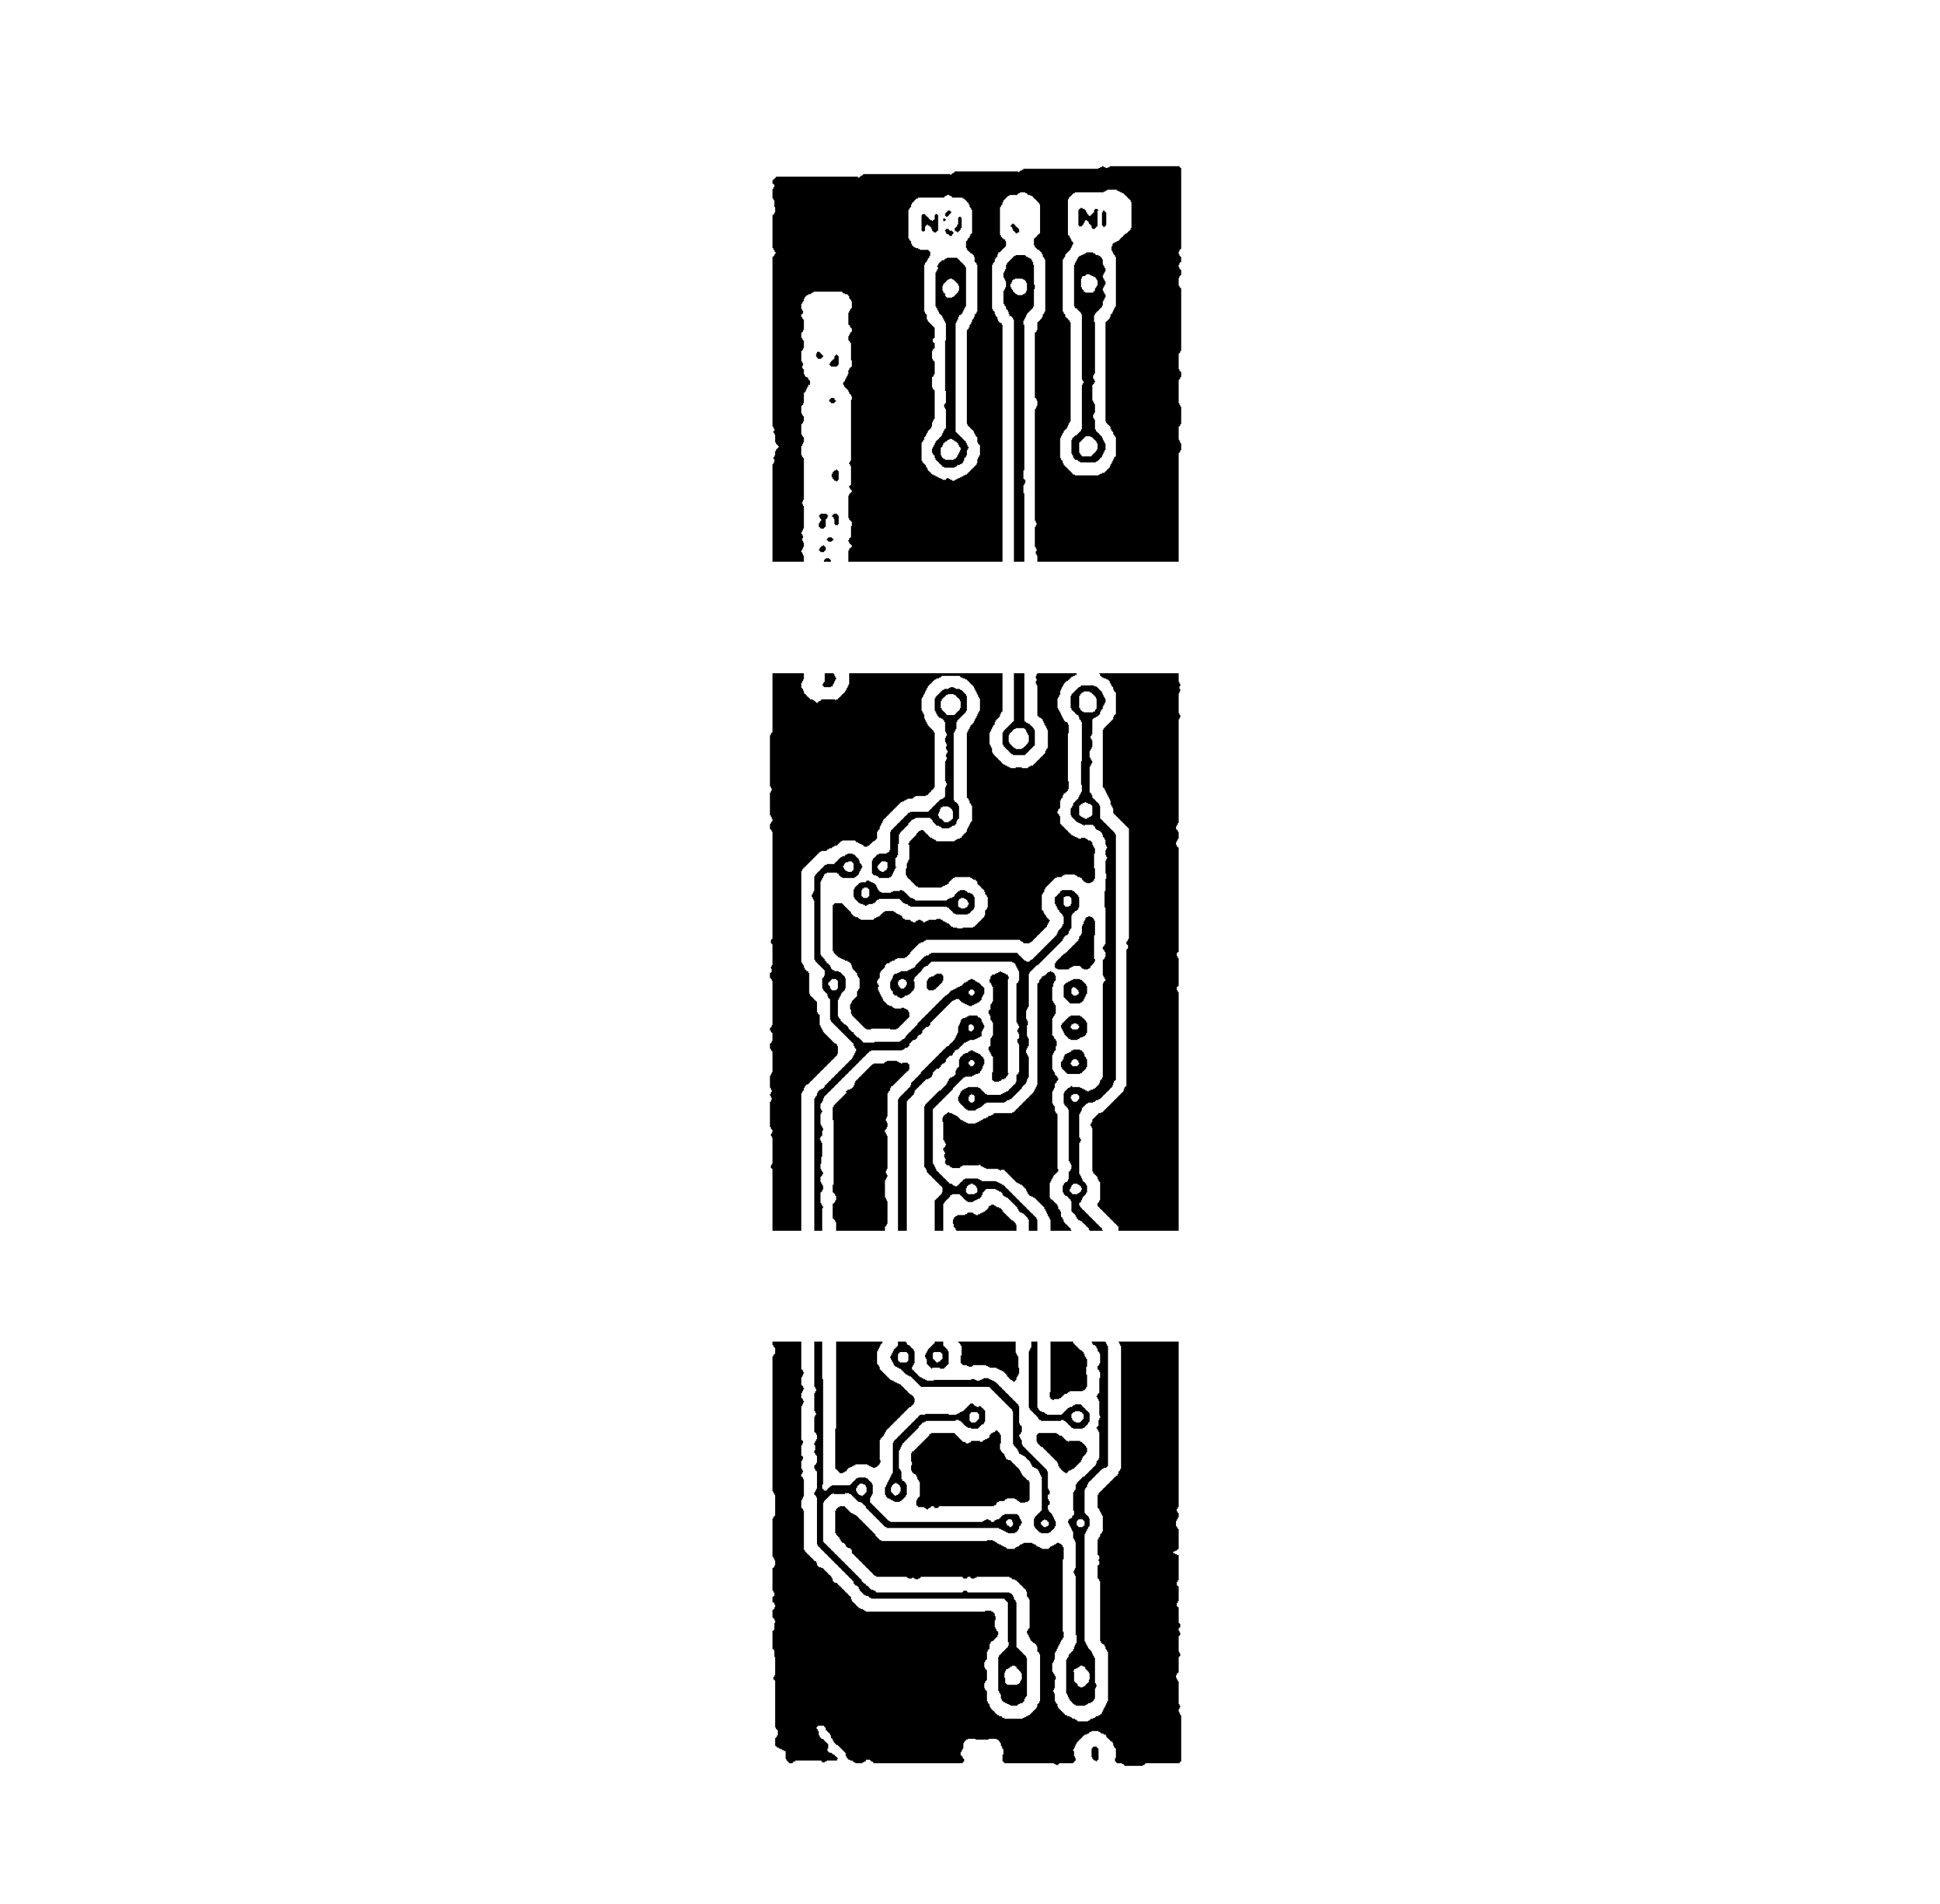

In [ ]:
show_sub_imgs(imgs)

1/1 [==============================] - 0s 33ms/step


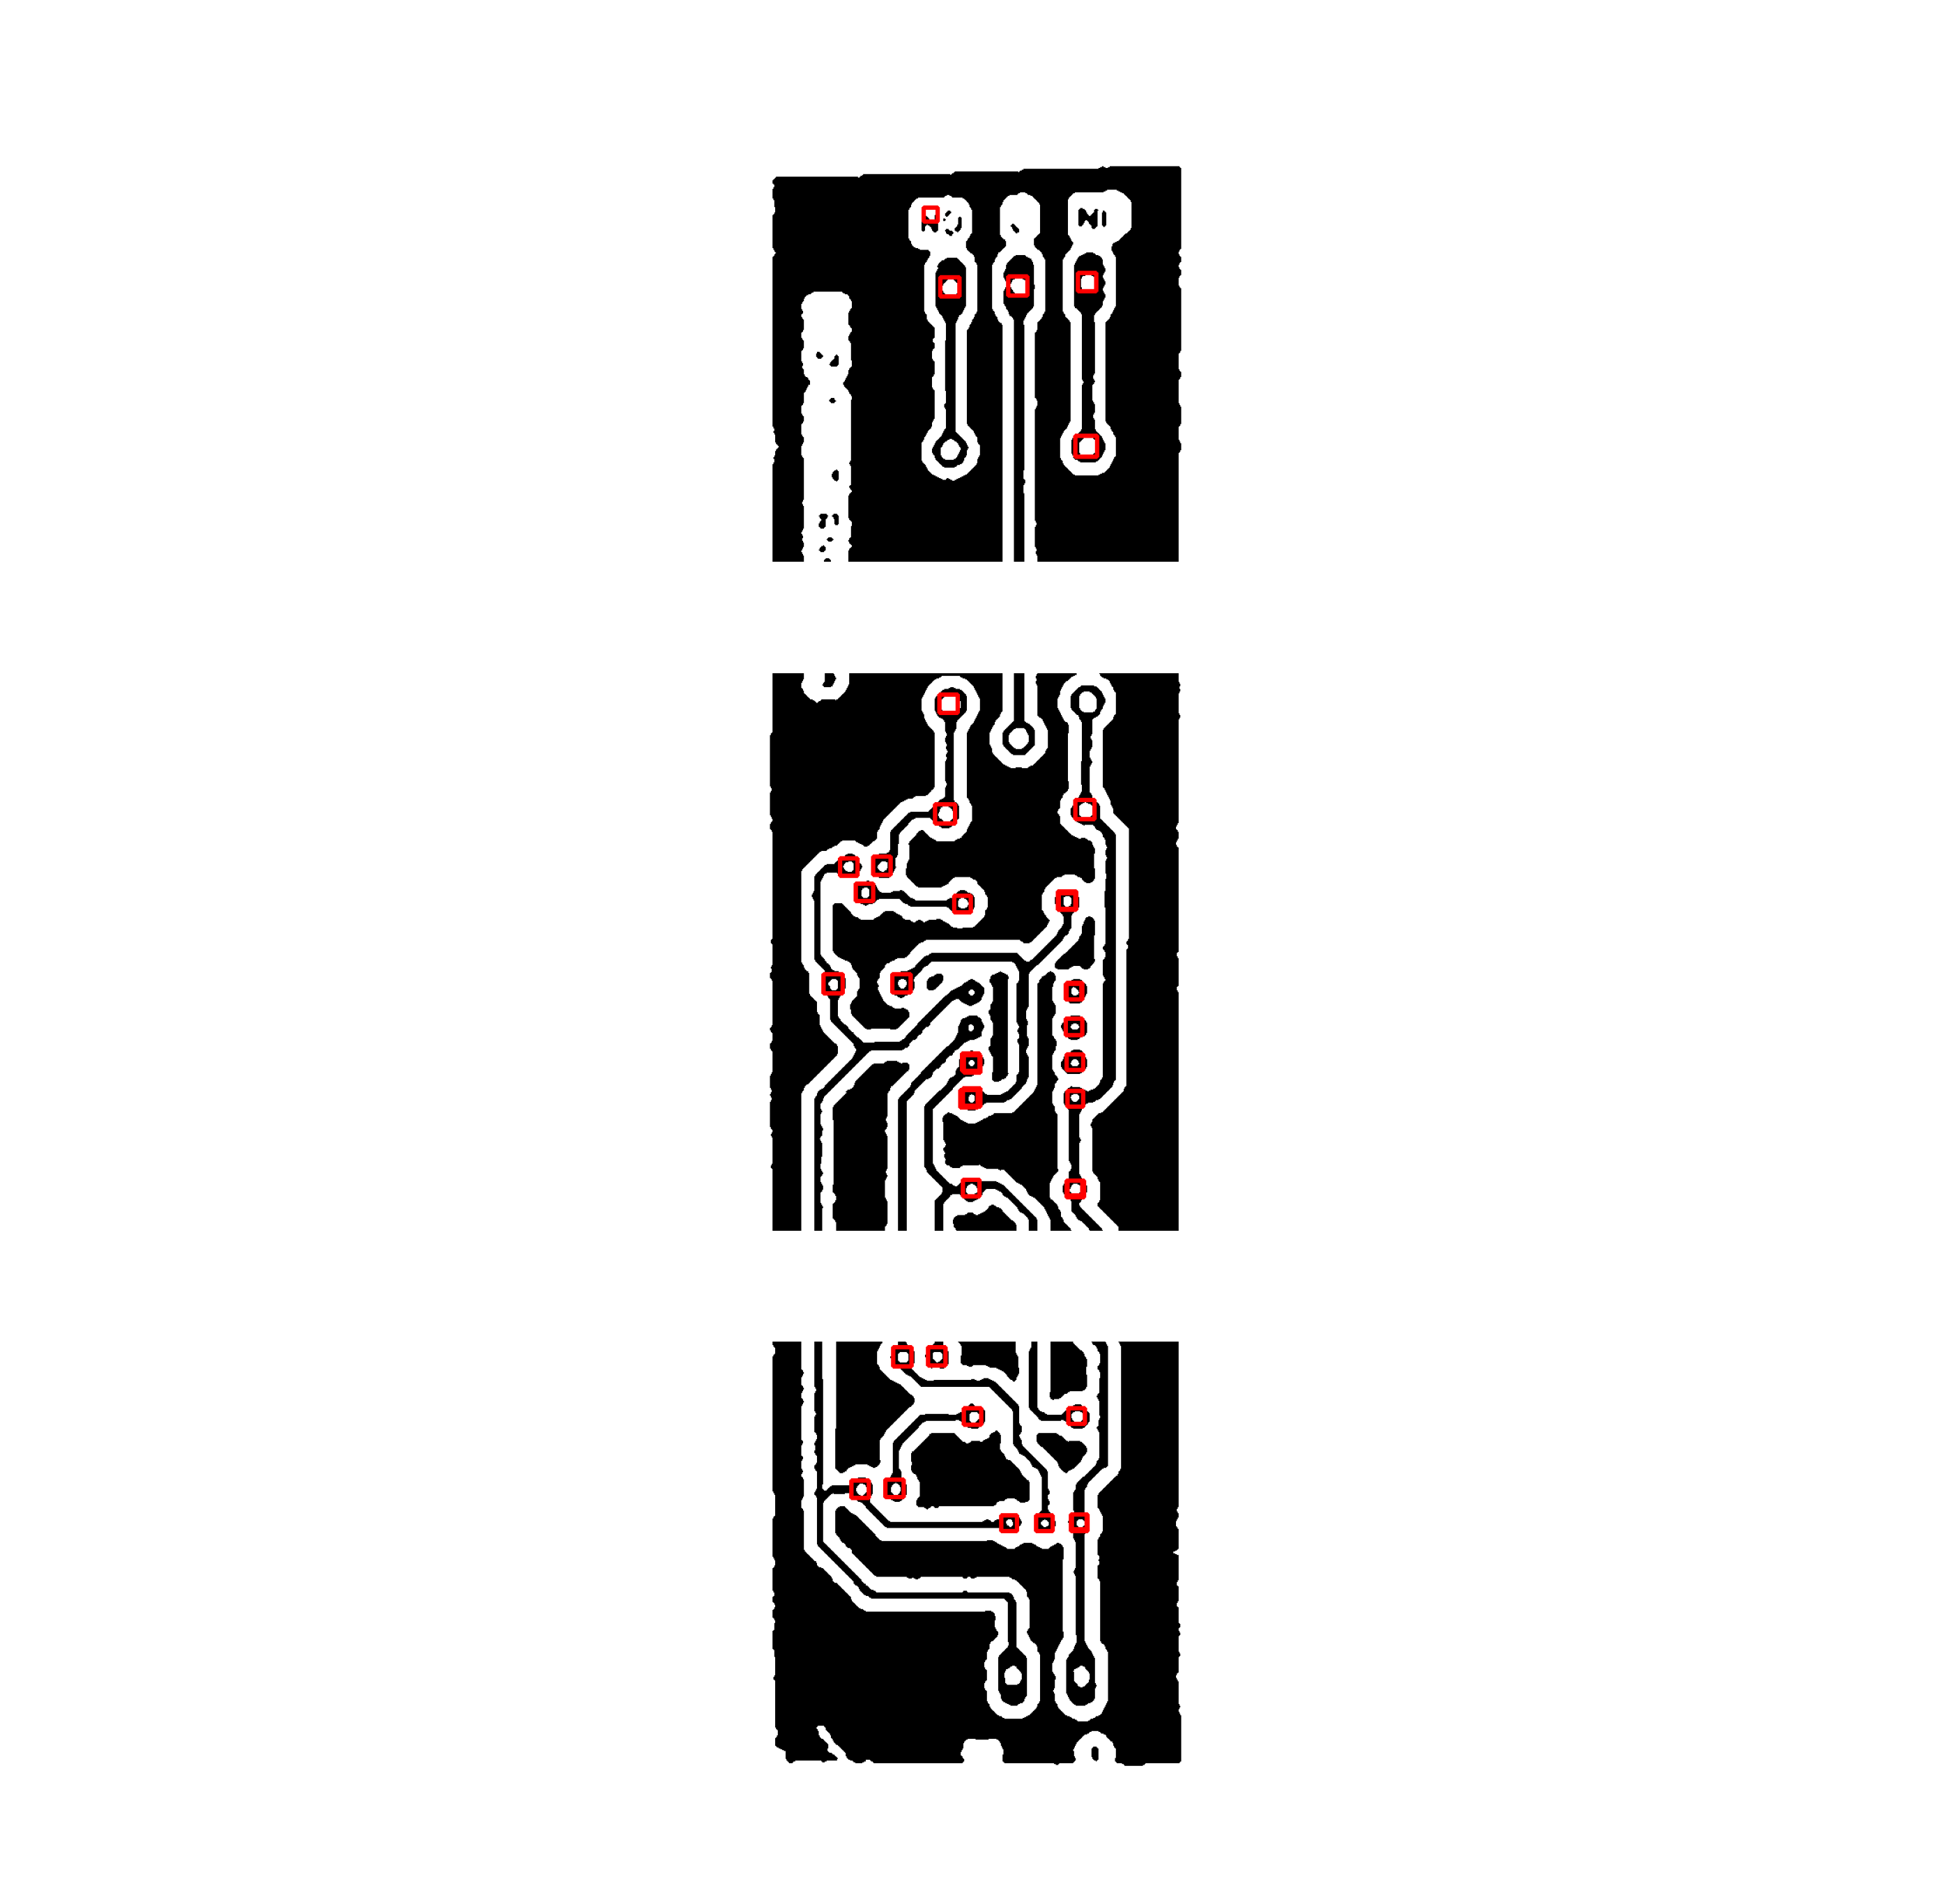

In [ ]:
show_multiple_predictions(np.stack(imgs, axis=0))